# Variability in pharmacokinetics
Pharmacokinetics is the study of how a drug moves through the body. The four primary aspects of pharmacokinetics are absorption, distribution, metabolism, and excretion (ADME). Pharmacokinetic variability refers to the differences in drug response among individuals due to various factors. Here are some key points about the factors that result in pharmacokinetic variability:

1. **Variability in Protein Amounts of Transporters and Proteins**: Proteins play a critical role in drug transportation and metabolism. Some proteins help to transport drugs across cell membranes, while others metabolize drugs in the body. The expression level and activity of these proteins can vary significantly among individuals due to genetic factors, disease states, or interaction with other substances, leading to variability in drug response. For example, changes in the activity of cytochrome P450 enzymes, a group of enzymes responsible for drug metabolism, can significantly impact the pharmacokinetics of a drug.

2. **Pharmacogenomic Variants**: Pharmacogenomics is the study of how an individual's genetic makeup affects their response to drugs. Variations in genes can significantly influence drug response by affecting the function of drug-metabolizing enzymes, drug transporters, and drug targets. For instance, certain genetic variants can cause a drug-metabolizing enzyme to metabolize a drug more slowly or more quickly, leading to changes in drug efficacy and toxicity.

3. **Physiological Factors**: Age, sex, body weight, organ function, and health status can significantly influence drug pharmacokinetics. For example, the elderly typically have decreased organ function and altered body composition, which can affect drug metabolism and distribution. Also, women and men may metabolize certain drugs differently due to differences in body composition and hormonal levels. Furthermore, diseases such as kidney or liver diseases can significantly affect drug metabolism and elimination, leading to changes in drug response.

4. **Environmental Factors**: Factors like diet, alcohol intake, smoking, and exposure to environmental toxins can also impact drug metabolism and drug response. For instance, grapefruit juice can inhibit the action of certain drug-metabolizing enzymes, leading to increased drug levels in the body.

5. **Drug-Drug Interactions**: Some drugs can affect the pharmacokinetics of other drugs by interacting with the same drug-metabolizing enzymes or transporters. For instance, one drug can inhibit the metabolism of another drug, leading to increased levels of the second drug in the body.

6. **Patient Compliance**: How well a patient adheres to their medication regimen can also influence drug response. Missed doses, incorrect timing, or improper administration can all impact the pharmacokinetics of a drug.

Understanding these factors is critical in personalized medicine, as it allows for the optimization of drug therapy based on an individual's unique characteristics, leading to improved drug efficacy and reduced adverse effects.

## Variability in Protein Amounts of Transporters and Proteins
A large part of the variability in drug metabolism within the population is due to individual protein amounts.

![Protein variability](08_variability_proteins.png)

![Absorption Elimination Model](04_simple_absorption.png)

In a first step we define the protein distribution from which we are going to sample. We are using a lognormal distribution, because most protein distributions can be approximated well with it.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

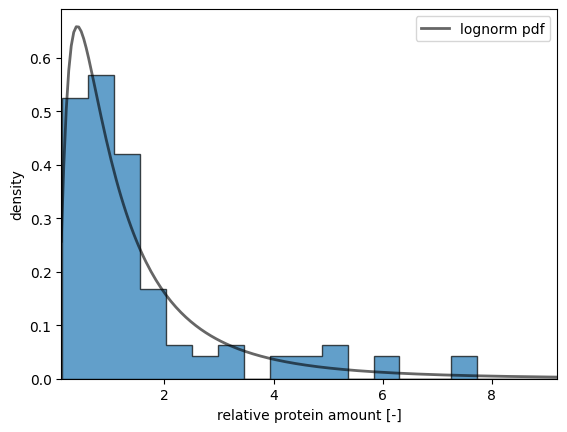

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

fig, ax = plt.subplots(1, 1)
s = 0.954

# Display the probability density function (pdf):
x = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 200)

ax.plot(x, lognorm.pdf(x, s), 'k-', lw=2, alpha=0.6, label='lognorm pdf')

n_samples = 100
f_proteins = lognorm.rvs(s, size=n_samples)

ax.hist(f_proteins, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black")
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best')
ax.set_xlabel("relative protein amount [-]")
ax.set_ylabel("density")
plt.show()
# print(f_proteins)

Now we simulate the resulting distribution of pharmacokinetics from such a distribution.

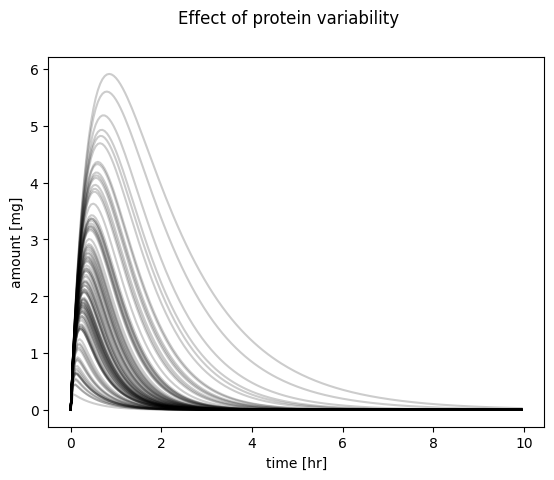

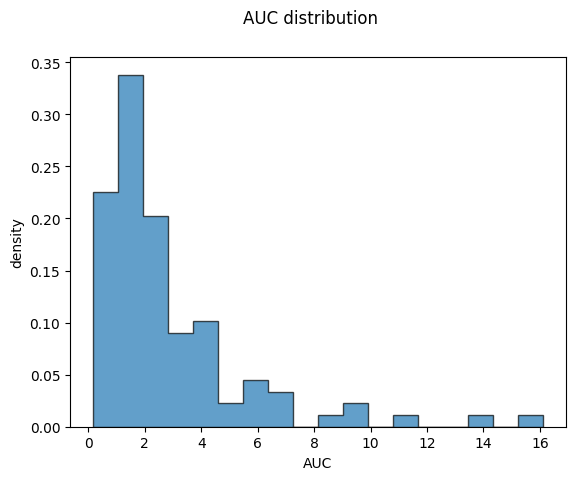

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate all genetic variants
tcs = []
pks = []

for f_protein in f_proteins:
    
    # the genetic variants effect the elimination/transport rate
    ke_protein = f_protein * ke 
    x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_protein))
    df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
    df["time"] = t
    tcs.append(df)
    
    # calculate pharmacokinetics parameters on the curves
    pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
    pks.append(pk)

    
# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Effect of protein variability")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")

for k, f_protein in enumerate(f_proteins):
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, color="black", alpha=0.2)
plt.show()

# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC distribution")
aucs = [pk["auc"] for pk in pks]
ax.hist(aucs, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black")

ax.set_xlabel("AUC")
ax.set_ylabel("density")
plt.show()

**Exercise**: How is the distribution for other pharmacokinetic parameters such as thalf, kel, ... in the population? Plot the histogram for additional pharmacokinetic parameters.

## Achieving the therapeutic range

In [3]:
def simulate_multi_dosing(Dose_A, ka, ke):
    """Helper function to run the multiple dosing simulation."""

    # initial condition
    names = ["A_tablet", "A_central", "A_urine"]
    x0 = [
        Dose_A,  # A_tablet  [mg]
        0.0,   # A_central [mg]
        0.0,   # A_urine [mg]
    ]

    # time span for single dose
    t = np.linspace(0, 24, num=100) # [hr]

    # multiple dose simulation
    n_doses = 10  # [hr]
    
    dfs = []
    for k in range(n_doses):
        if k == 0:
            # x0[0] = 400   # first dose
            tvec = t.copy()
        elif k > 0:
            x0 = x[-1, :]
            x0[0] = x0[0] + Dose_A
            tvec = t.copy() + tvec[-1]

        x = odeint(dxdt_absorption_first_order, x0, tvec, args=(ka, ke))
        df = pd.DataFrame(x, columns=names)
        df["time"] = tvec
        dfs.append(df)

    df_all = pd.concat(dfs)
    return df_all

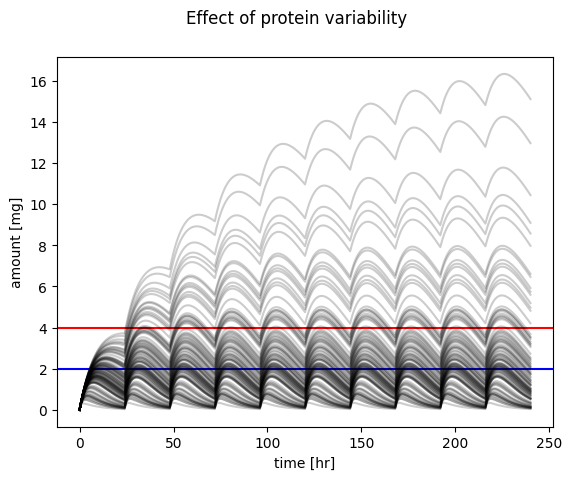

In [4]:
# run simulation and plot results
Dose_A = 5.0  # [mg]
ka = 0.1  # [1/hr]
ke = 0.1  # [1/hr]


# simulate multi dosing
tcs = []
pks = []
for f_protein in f_proteins:
    
    # the genetic variants effect the elimination/transport rate
    ke_protein = f_protein * ke 
    
    df = simulate_multi_dosing(Dose_A, ka, ke_protein)
    tcs.append(df)

    
# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Effect of protein variability")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")
ax.axhline(y=4, color='r', linestyle='-', label="MTC")
ax.axhline(y=2, color='b', linestyle='-', label="MEC")

for k, f_protein in enumerate(f_proteins):
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, color="black", alpha=0.2)
plt.show()

**Exercise**: Try now to perform a dosing optimization for the population. I.e. change ka, ke and Dose_A to optimize the theraphy.

## Stratification
Often these distributions are different for different subsets of the population. This information can be used for so called stratification of the models, i.e., applying the models to different subgroups.

We now study the difference between male and females via the assumption that protein distributions differ between the groups.

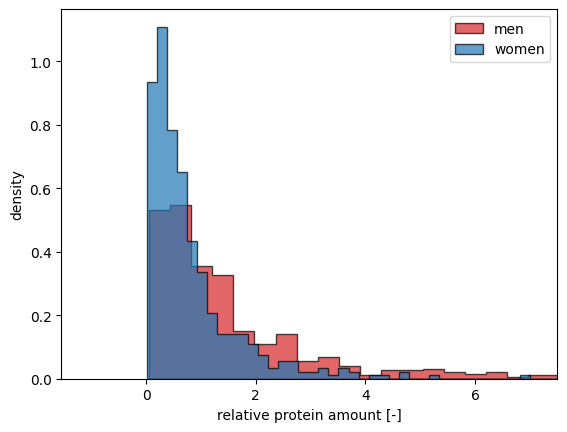

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

fig, ax = plt.subplots(1, 1)
s_men = 1
scale_men=1
s_women = 20
scale_women=0.5

n_samples = 500
f_proteins_men = lognorm.rvs(s_men, scale=scale_men, size=n_samples)
f_proteins_women = lognorm.rvs(s_men, scale=scale_women, size=n_samples)

ax.hist(f_proteins_men, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black", color="tab:red", label="men")
ax.hist(f_proteins_women, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black", color="tab:blue", label="women")

ax.legend(loc='best')
ax.set_xlabel("relative protein amount [-]")
ax.set_ylabel("density")
ax.set_xlim(right=7.5)
plt.show()
# print(f_proteins)

/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])


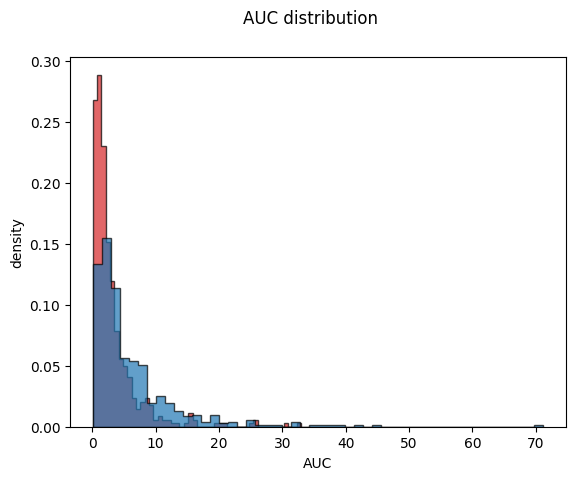

In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate all genetic variants
tcs_dict = {}
pks_dict = {}

for key in ["men", "women"]:
    tcs = []
    pks = []

    if key == "men":
        f_proteins = f_proteins_men
    elif key == "women":
        f_proteins = f_proteins_women
    
    for f_protein in f_proteins:

        # the genetic variants effect the elimination/transport rate
        ke_protein = f_protein * ke 
        x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_protein))
        df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
        df["time"] = t
        tcs.append(df)

        # calculate pharmacokinetics parameters on the curves
        pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
        pks.append(pk)
    tcs_dict[key] = tcs
    pks_dict[key] = pks
    
# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC distribution")
for key in ["men", "women"]:
    pks = pks_dict[key]

    if key == "men":
        color = "tab:red"
    elif key == "women":
        color = "tab:blue"
    
    aucs = [pk["auc"] for pk in pks]
    ax.hist(aucs, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
            edgecolor="black", color=color)

ax.set_xlabel("AUC")
ax.set_ylabel("density")
plt.show()

## Pharmacogenetic Variants
Pharmacogenomics is the study of how an individual's genetic makeup influences their response to drugs. This field combines pharmacology (the science of drugs) and genomics (the study of genes and their functions) to develop effective, safe medications and doses that will be tailored to a person's genetic makeup.

Pharmacogenomics is a part of the broader field of personalized medicine, which aims to tailor medical treatment to the individual characteristics of each patient.

With respect to pharmacokinetics (the study of how the body absorbs, distributes, metabolizes, and excretes drugs), pharmacogenomics can provide valuable insights. For instance:

1. **Absorption and Distribution:** Genetic differences can affect the expression and function of proteins involved in drug transport across cell membranes, influencing how quickly and effectively a drug is absorbed or distributed within the body.

2. **Metabolism:** A key aspect of pharmacokinetics is understanding how drugs are metabolized, primarily by enzymes in the liver. Individual genetic variations can affect the activity of these enzymes, leading to differences in how quickly a drug is metabolized. For example, some individuals may have genetic variations that cause certain enzymes to be overly active ("ultra-metabolizers") or underactive ("poor metabolizers"). This can significantly impact the concentration of drug in the body and therefore its efficacy and potential for side effects.

3. **Excretion:** Variations in genes can also impact the function of proteins involved in the excretion of drugs, primarily in the kidneys, affecting the rate at which a drug is removed from the body.

By understanding an individual's pharmacogenomic profile, healthcare providers can better predict how a patient will respond to a particular drug, informing decisions about which drug to prescribe and at what dose. This can improve drug efficacy, reduce the risk of adverse effects, and contribute to more efficient and safer healthcare. However, it's important to note that while pharmacogenomics holds great promise, its application in routine clinical practice is currently limited, though it's an area of active research and development.

- Pharmacogenomic Variants of SLC0B11 ...
- Provide table with variants and activity; simulate additional variants; 2 alleles & effect of multiple copies
- Combination with variability

The following defines the activity of the allels of the SLCO1B1 transporter.
We focus on the subset of important genetic variants `*1a`, `*1b`, `*15` and possible combinations

In [7]:
# SLCO1B1
# f_sclo1b1
f_wildtype = 1.0  # *1a wildtype activity
f_increase = 1.1  # *1b has slightly increased activity
f_decrease = 0.5  # all variants with the 521T/C mutant have strongly reduced activity, e.g., *15

slco1b1_activity = {
    # strong increase (dark blue)
    "*1b/*1b": (f_increase + f_increase) / 2,
    
    # mild increase (light blue)
    "*1a/*1b": (f_wildtype + f_increase) / 2,
    
    # wildtype (black)
    "*1a/*1a": (f_wildtype + f_wildtype)/2,
    
    # minor decrease (orange)
    "*1b/*15": (f_increase + f_decrease) / 2,
    
    # mild decrease (red)
    "*1a/*15": (f_wildtype + f_decrease) / 2,

    # strong decrease (dark red)
    "*15/*15": (f_decrease + f_decrease) / 2,
}
slco1b1_color = {
        "*1b/*1b": "blue",
        "*1a/*1b": "tab:blue",
        "*1a/*1a": "black",
        "*1b/*15": "tab:orange",
        "*1a/*15": "tab:red",
        "*15/*15": "red",
}

![Absorption Elimination Model](04_simple_absorption.png)

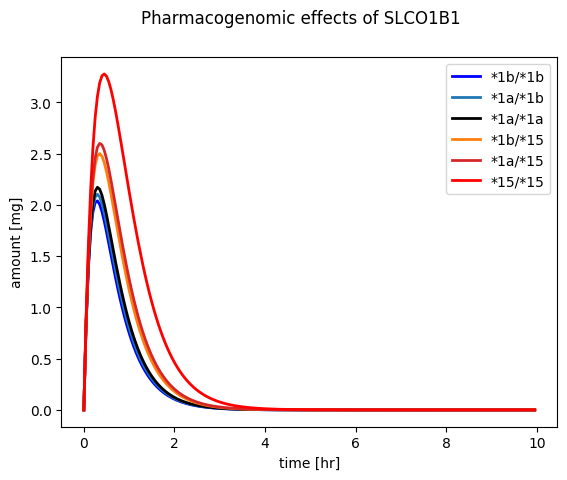

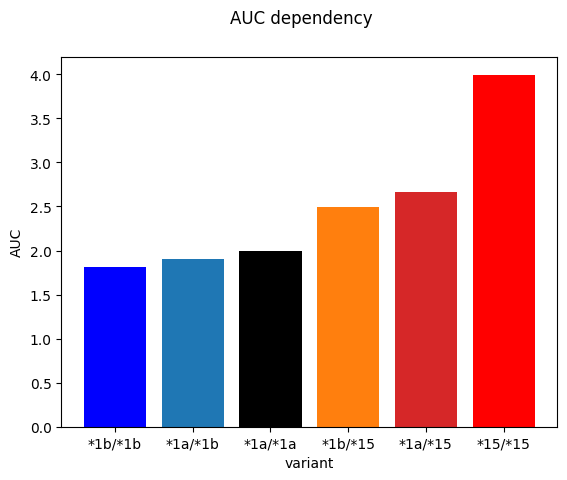

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate all genetic variants
tcs = []
pks = []

for variant, f_activity in slco1b1_activity.items():
    
    # the genetic variants effect the elimination/transport rate
    ke_variant = f_activity * ke 
    x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_variant))
    df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
    df["time"] = t
    tcs.append(df)
    
    # calculate pharmacokinetics parameters on the curves
    pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
    pks.append(pk)

    
# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Pharmacogenomic effects of SLCO1B1")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")

for k, variant in enumerate(slco1b1_activity):
    color = slco1b1_color[variant]
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, linewidth=2, color=color, label=variant)

ax.legend()
plt.show()

# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC dependency")

aucs = [pk["auc"] for pk in pks]
variants = list(slco1b1_activity.keys())
colors = [slco1b1_color[v] for v in variants]

ax.bar(
    x=range(len(aucs)), height=aucs, 
    color=colors, 
    tick_label=variants
)
ax.set_xlabel("variant")
ax.set_ylabel("AUC")


plt.show()

**Exercise 1**: Study the effect of the genetic variants on other pharmacokinetic parameters such as CL, thalf, ...

**Exercise 2**: Add an additional newly discovered variant `*f` to the analysis which has 2.0 activity compared to the wildtype variant.